# Cell 1 — Title and overview

# Logistic Regression — Intuition, math, scikit-learn and implementation from scratch

This notebook covers:
- The sigmoid function and why logistic regression outputs probabilities.
- Log-likelihood and cross-entropy loss.
- Training with gradient descent.
- Using `sklearn.linear_model.LogisticRegression`.
- A vectorized from-scratch implementation (`LogisticRegressionScratch`) with optional L2 regularization.
- Visualizations: sigmoid curve, decision boundary, probability contours, and loss curve.


In [1]:
# Cell 2 — Imports (run once)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as SklearnLogistic
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, log_loss
import seaborn as sns
sns.set()
np.random.seed(42)


# Cell 3 — Intuition in words

Logistic Regression is a **linear model for classification**.  
It computes a linear combination of input features:


$$


z = \mathbf{w}^\top \mathbf{x} + b

$$

Then passes \(z\) through the **sigmoid** function to produce a probability for the positive class \(P(y=1 \mid \mathbf{x})\).

The sigmoid is:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Output $ \sigma(z) $ is in $ (0,1) $ and we pick a threshold (usually 0.5) to decide the class.


# Cell 4 — Sigmoid visualization


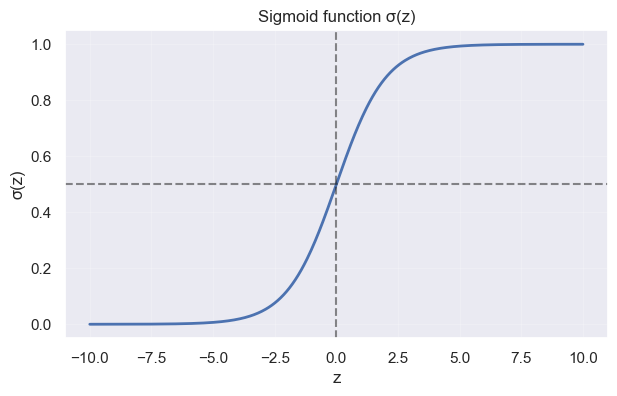

In [2]:
# Cell 5 — Plot sigmoid
z = np.linspace(-10, 10, 500)
sigma = 1 / (1 + np.exp(-z))

plt.figure(figsize=(7,4))
plt.plot(z, sigma, lw=2)
plt.axvline(0, color='k', ls='--', alpha=0.5)
plt.axhline(0.5, color='k', ls='--', alpha=0.5)
plt.title("Sigmoid function σ(z)")
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.grid(alpha=0.2)
plt.show()


# Cell 6 — Probabilistic model & loss (math)

We model the conditional probability:

$$
P(y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b)
$$

For a training dataset $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$ with $y_i \in \{0,1\}$, the likelihood of all labels is:

$$
L(\mathbf{w}, b) = \prod_{i=1}^N \sigma(z_i)^{y_i} (1-\sigma(z_i))^{1-y_i}
\quad\text{where } z_i = \mathbf{w}^\top \mathbf{x}_i + b
$$

We maximize the log-likelihood (equivalently minimize negative log-likelihood, aka **binary cross-entropy**):

$$
\ell(\mathbf{w}, b) = -\sum_{i=1}^N \big[ y_i \log\sigma(z_i) + (1-y_i)\log(1-\sigma(z_i)) \big]
$$

This is the loss we will minimize.


# Cell 7 — Gradient (derivation summary)

The gradient of the loss with respect to weights \( \mathbf{w} \) is:

$$
\frac{\partial \ell}{\partial \mathbf{w}}
= \sum_{i=1}^N (\sigma(z_i) - y_i)\,\mathbf{x}_i
$$

and bias gradient:

$$
\frac{\partial \ell}{\partial b}
= \sum_{i=1}^N (\sigma(z_i) - y_i)
$$

This leads to a simple vectorized gradient descent update:

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \,\frac{1}{N}\sum_{i=1}^N (\sigma(z_i) - y_i)\mathbf{x}_i
$$
$$
b \leftarrow b - \eta \,\frac{1}{N}\sum_{i=1}^N (\sigma(z_i) - y_i)
$$

where $\eta$ is learning rate.


# Cell 8 — Synthetic 2D dataset (for visualization)


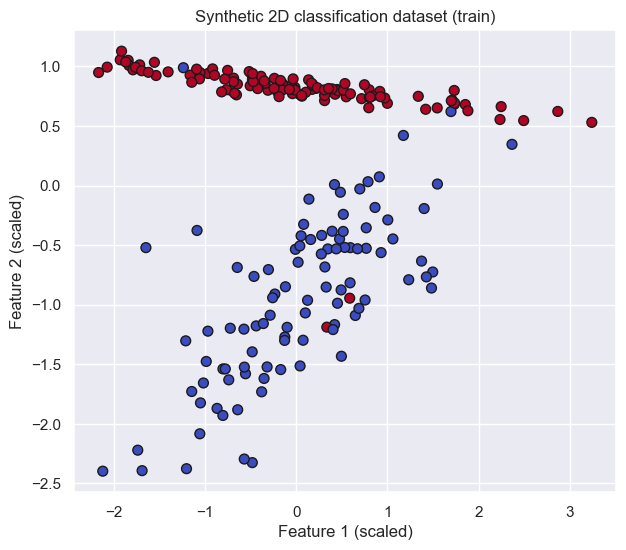

In [3]:
# Cell 9 — Create and show 2D dataset
X, y = make_classification(
    n_samples=300, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=1.2, random_state=2
)

# split & scale for stability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

plt.figure(figsize=(7,6))
plt.scatter(X_train_s[:,0], X_train_s[:,1], c=y_train, cmap='coolwarm', edgecolor='k', s=50)
plt.title("Synthetic 2D classification dataset (train)")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()


# Cell 10 — Train and evaluate with scikit-learn

We'll fit `sklearn.linear_model.LogisticRegression` (default solver may use L2 regularization).


In [13]:
from sklearn.linear_model import LogisticRegression as SklearnLogistic
from sklearn.metrics import accuracy_score, log_loss

# Cell 11 — scikit-learn logistic regression
sk_clf = SklearnLogistic(
    penalty=None,          # <-- FIXED
    solver='lbfgs',        # lbfgs supports no penalty
    max_iter=5000
)

sk_clf.fit(X_train_s, y_train)

y_pred = sk_clf.predict(X_test_s)
y_proba = sk_clf.predict_proba(X_test_s)[:, 1]

print("Accuracy (sklearn):", accuracy_score(y_test, y_pred))
print("Log-loss (sklearn):", log_loss(y_test, sk_clf.predict_proba(X_test_s)))


Accuracy (sklearn): 0.9333333333333333
Log-loss (sklearn): 0.20507641255796416


# Cell 12 — Decision boundary and probability contours (sklearn model)

We will visualize the learned linear boundary and probability background.


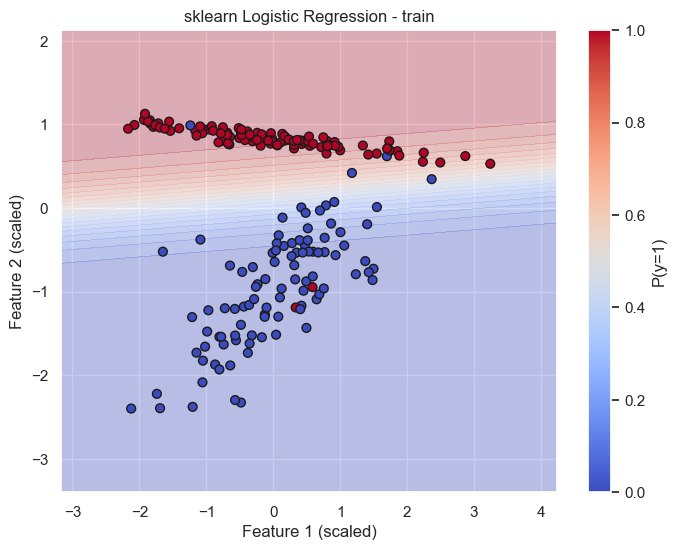

In [14]:
# Cell 13 — Plot decision boundary + probabilities
def plot_decision_boundary(clf, X, y, title="Decision boundary"):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,300), np.linspace(y_min,y_max,300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:,1].reshape(xx.shape)
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, probs, alpha=0.3, levels=20, cmap='coolwarm')
    plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', edgecolor='k', s=40)
    plt.colorbar(label='P(y=1)')
    plt.title(title)
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.show()

plot_decision_boundary(sk_clf, X_train_s, y_train, title="sklearn Logistic Regression - train")


# Cell 14 — From-scratch logistic regression (vectorized, with gradient descent and optional L2)

We'll implement:
- `fit(X, y, lr, epochs, l2=0.0)` — gradient descent
- `predict_proba(X)` — sigmoid output
- `predict(X)` — threshold 0.5
- Track loss history


In [6]:
# Cell 15 — Implementation from scratch
class LogisticRegressionScratch:
    def __init__(self, lr=0.1, epochs=1000, fit_intercept=True, l2=0.0, verbose=False):
        self.lr = lr
        self.epochs = epochs
        self.fit_intercept = fit_intercept
        self.l2 = float(l2)
        self.verbose = verbose
        self.loss_history = []
        self.w = None
        self.b = None

    @staticmethod
    def _sigmoid(z):
        # Numerically stable sigmoid
        return 1 / (1 + np.exp(-z))

    def _initialize(self, n_features):
        self.w = np.zeros(n_features)
        self.b = 0.0

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        self._initialize(n_features)

        for epoch in range(self.epochs):
            z = X.dot(self.w) + self.b
            y_hat = self._sigmoid(z)

            # Loss (binary cross-entropy) with L2 penalty (exclude bias)
            eps = 1e-15
            loss = -np.mean(y * np.log(y_hat + eps) + (1 - y) * np.log(1 - y_hat + eps))
            if self.l2 > 0:
                loss += (self.l2 / (2)) * np.sum(self.w ** 2)
            self.loss_history.append(loss)

            # Gradients
            error = y_hat - y
            dw = (X.T.dot(error)) / n_samples + self.l2 * self.w
            db = np.sum(error) / n_samples

            # Update
            self.w -= self.lr * dw
            self.b -= self.lr * db

            if self.verbose and (epoch % (self.epochs // 10 + 1) == 0):
                print(f"Epoch {epoch:4d}/{self.epochs} — loss: {loss:.5f}")

        return self

    def predict_proba(self, X):
        X = np.array(X)
        z = X.dot(self.w) + self.b
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


# Cell 16 — Train scratch model and compare with sklearn


In [7]:
# Cell 17 — Fit scratch model
scratch = LogisticRegressionScratch(lr=0.5, epochs=2000, l2=0.01, verbose=False)
scratch.fit(X_train_s, y_train)

y_pred_scratch = scratch.predict(X_test_s)
print("Accuracy (scratch):", accuracy_score(y_test, y_pred_scratch))
print("Final loss (scratch):", scratch.loss_history[-1])


Accuracy (scratch): 0.9222222222222223
Final loss (scratch): 0.22465479282779327


# Cell 18 — Plot loss curve (scratch)


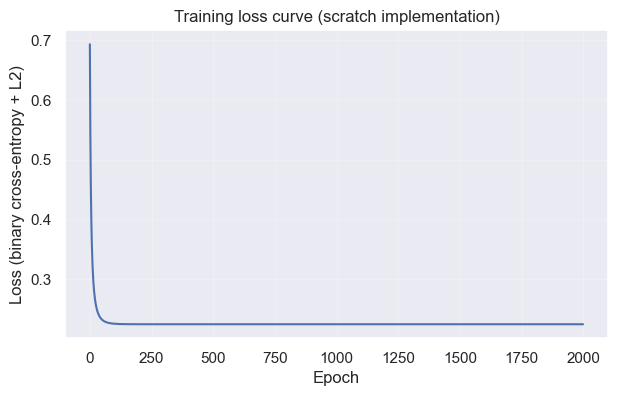

In [8]:
# Cell 19 — Loss curve
plt.figure(figsize=(7,4))
plt.plot(scratch.loss_history)
plt.title("Training loss curve (scratch implementation)")
plt.xlabel("Epoch")
plt.ylabel("Loss (binary cross-entropy + L2)")
plt.grid(alpha=0.2)
plt.show()


# Cell 20 — Decision boundary & probability contours (scratch)


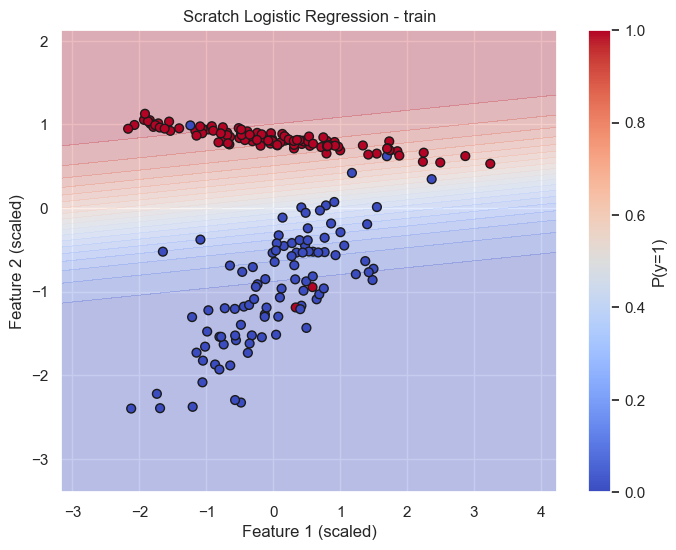

In [9]:
# Cell 21 — wrap scratch into an object with sklearn-like predict_proba for plotting
class _PredictableWrapper:
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        probs = self.model.predict_proba(X)
        return np.vstack([1-probs, probs]).T

# Plot
plot_decision_boundary(_PredictableWrapper(scratch), X_train_s, y_train, title="Scratch Logistic Regression - train")


# Cell 22 — Compare weights (sklearn vs scratch)

Because of scaling and possible solver differences, weights should be similar in direction and magnitude.


In [15]:
# Cell 23 — Compare coefficients
print("sklearn coef, intercept:", sk_clf.coef_, sk_clf.intercept_)
print("scratch   w, b        :", scratch.w, scratch.b)


sklearn coef, intercept: [[-0.31531517  4.84482949]] [-0.74605701]
scratch   w, b        : [-0.25715202  3.1293815 ] -0.2005515088119355


# Cell 24 — Tips, hyperparameters and interpretation

- **Feature scaling** (StandardScaler) improves convergence for gradient descent.
- **Learning rate (`lr`)**: too large → diverge; too small → slow. Watch the loss curve.
- **Epochs**: enough to converge. Loss curve shows progress.
- **Regularization (`l2`)**: prevents large weights and overfitting. L1 (sparse) not implemented here but conceptually similar (adds |w| penalty).
- **Interpretation**: each weight \(w_j\) is the log-odds change per unit increase in \(x_j\) (holding others fixed).
  - Log-odds: \(\log\frac{P(y=1)}{P(y=0)} = \mathbf{w}^\top \mathbf{x} + b\).
  - Odds ratio for a one-unit increase in \(x_j\): \(e^{w_j}\).

Common checklist:
- Check loss decreases.
- Check ROC/AUC and confusion matrix depending on threshold.
- Try different thresholds based on precision/recall trade-off.


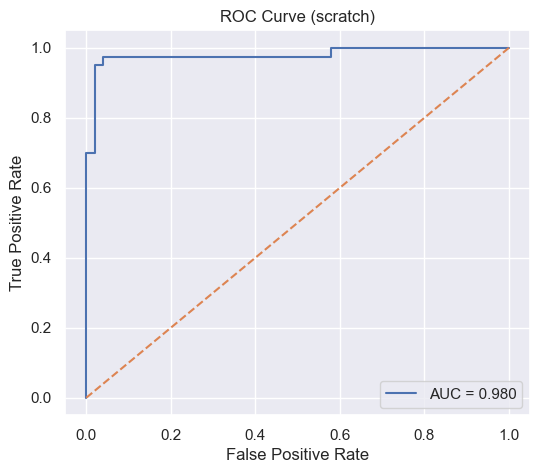

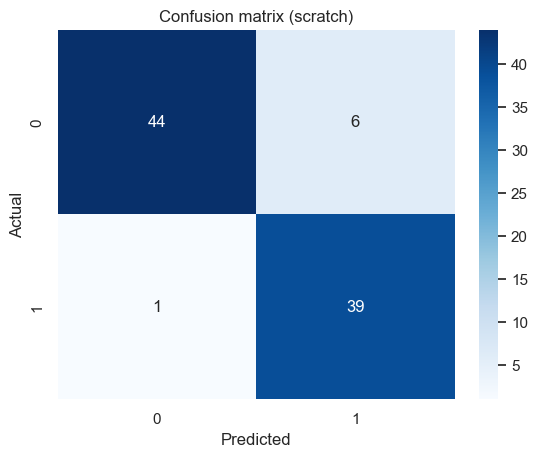

In [12]:
# Cell 25 — Quick evaluation: confusion matrix and ROC for scratch
y_proba_scratch = scratch.predict_proba(X_test_s)
fpr, tpr, _ = roc_curve(y_test, y_proba_scratch)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (scratch)")
plt.legend()
plt.show()

cm = confusion_matrix(y_test, y_pred_scratch)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix (scratch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Cell 26 — Final notes & exercises

**Exercises you can try**
1. Implement L1 regularization in `LogisticRegressionScratch` (proximal update or subgradient).
2. Replace batch gradient descent by mini-batch or stochastic gradient descent.
3. Compare `penalty='l2'` sklearn solver with different regularization strengths (`C` parameter).
4. Train on a real dataset (Iris — convert to binary) and report AUC and confusion matrix.
5. Plot decision boundary when feature transformations are added (e.g., polynomial features) to see non-linear separation with logistic model.

